In [416]:
import cv2
import glob
import os
import datetime
import numpy as np
import os.path as osp
from pathlib import Path

import torch
from dpvo.dpvo import DPVO
from dpvo.utils import Timer
from dpvo.config import cfg

import torch
import numpy as np
import torch.nn.functional as F

from dpvo.extractor import * 

import torch.quantization.quantize_fx as quantize_fx
import copy

from pprint import pprint

In [46]:
config = "../config/default.yaml"
# DPVO.load_weights(cfg.merge_from_file(config) ,"../dpvo.pth")

slam = DPVO(cfg, "../dpvo.pth", ht=480, wd=640, viz=False)


In [52]:
extractor = slam.network.patchify.fnet

In [140]:
checkpoint = "../dpvo.pth"



direct = BasicEncoder4()

direct.load_state_dict(torch.load(checkpoint, map_location=torch.device('cpu')), strict=False)



_IncompatibleKeys(missing_keys=['norm1.weight', 'norm1.bias', 'norm1.running_mean', 'norm1.running_var', 'conv1.weight', 'conv1.bias', 'layer1.0.conv1.weight', 'layer1.0.conv1.bias', 'layer1.0.conv2.weight', 'layer1.0.conv2.bias', 'layer1.0.norm1.weight', 'layer1.0.norm1.bias', 'layer1.0.norm1.running_mean', 'layer1.0.norm1.running_var', 'layer1.0.norm2.weight', 'layer1.0.norm2.bias', 'layer1.0.norm2.running_mean', 'layer1.0.norm2.running_var', 'layer1.1.conv1.weight', 'layer1.1.conv1.bias', 'layer1.1.conv2.weight', 'layer1.1.conv2.bias', 'layer1.1.norm1.weight', 'layer1.1.norm1.bias', 'layer1.1.norm1.running_mean', 'layer1.1.norm1.running_var', 'layer1.1.norm2.weight', 'layer1.1.norm2.bias', 'layer1.1.norm2.running_mean', 'layer1.1.norm2.running_var', 'layer2.0.conv1.weight', 'layer2.0.conv1.bias', 'layer2.0.conv2.weight', 'layer2.0.conv2.bias', 'layer2.0.norm1.weight', 'layer2.0.norm1.bias', 'layer2.0.norm1.running_mean', 'layer2.0.norm1.running_var', 'layer2.0.norm2.weight', 'layer2

In [63]:
import functools
# See https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects
def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)

# using wonder's beautiful simplification: https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects/31174427?noredirect=1#comment86638618_31174427

def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

In [302]:
trained = rgetattr(extractor.conv1, 'weight')

d_weights = rgetattr(direct.conv1, 'weight')


In [458]:
# def quantize_model(model, args): 
#     bits = 6
#     for i in range(0, len(model.features)): 
#         l = model.features[i]
#         if type(l) == nn.Conv2d:
#             model.features[i] = QConv2d('uniform', bits,l.weight, *(l.in_channels, l.out_channels, l.kernel_size, l.stride, l.padding))
#         elif type(l) == Fire:
#             l.squeeze = QConv2d('uniform', bits, l.squeeze.weight, *(l.squeeze.in_channels, l.squeeze.out_channels, l.squeeze.kernel_size, l.squeeze.stride, l.squeeze.padding))
#             l.expand1x1 = QConv2d('uniform', bits, l.expand1x1.weight, *(l.expand1x1.in_channels, l.expand1x1.out_channels, l.expand1x1.kernel_size, l.expand1x1.stride, l.expand1x1.padding))
#             l.expand3x3 = QConv2d('uniform', bits, l.expand3x3.weight, *(l.expand3x3.in_channels, l.expand3x3.out_channels, l.expand3x3.kernel_size, l.expand3x3.stride, l.expand3x3.padding))

#     for i in range(0, len(model.classifier)):
#         if type(model.classifier[i]) == nn.Conv2d:
#             l = model.classifier[i]
#             model.classifier[i] = QConv2d('uniform', bits, l.weight, *(l.in_channels, l.out_channels, l.kernel_size, l.stride, l.padding)) 
    
#     return model


def quantize_uniform(data, n_bits, clip, device='cuda'): 
    clip = .5
    w_c = data.clamp(-clip, clip)
    b = torch.pow(torch.tensor(2.0), 1 - n_bits).to(device)
    w_q = clip * torch.min(b * torch.round(w_c / (b * clip)), 1 - b) 
    return w_q


class QConv2d(nn.Conv2d):
    def __init__(self, quant_scheme, quant_args=None, init_args=None, b=None, *kargs, **kwargs):
        super(QConv2d, self).__init__(*kargs, **kwargs) 
        self.weight = init_args
        self.bias = b
        self.quant_args = quant_args

        for k, v in kwargs.items():
            setattr(self, k, v)


        print("setting bias to ", self.bias.shape)

    def forward(self, inputs):
        self.quantize_params()
        return F.conv2d(inputs, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

    def quantize_params(self):
        unquantized_weights = rgetattr(self,'weight')
        # self.bias = rgetattr(self,'bias')
        quantized_weights = torch.nn.Parameter(quantize_uniform(unquantized_weights,self.quant_args,1,'cpu')) 
        # print(quantized_weights)
        rsetattr(self, 'weight', quantized_weights)
        return


In [459]:
copy_model = copy.deepcopy(extractor)

layers = dict(copy_model.named_modules())

In [460]:
copy_model.conv2.weight.shape

torch.Size([128, 64, 1, 1])

In [480]:
conv_layers = []
for item in layers:
    if "conv" in item:
        conv_layers.append(item)
        W = layers[item].weight
        print("haodaod", W.shape)

        kwargs = {
            "in_channels": W.shape[0],
            "out_channels": W.shape[1],
            "kernel_size": W.shape[2],
            "stride": layers[item].stride[0],
            "padding": layers[item].padding[0],
            "dilation": layers[item].dilation[0],
            "groups": layers[item].groups,
            # "bias": layers[item].bias,
        }

        print("little piece of shit" , layers[item].bias.shape)
        b = layers[item].bias

        new_layer = QConv2d('uniform', 8, W, b, **kwargs)        
        setattr(copy_model, item, new_layer)

haodaod torch.Size([32, 3, 7, 7])
little piece of shit torch.Size([32])
setting bias to  torch.Size([32])
haodaod torch.Size([32, 32, 3, 3])
little piece of shit torch.Size([32])
setting bias to  torch.Size([32])
haodaod torch.Size([32, 32, 3, 3])
little piece of shit torch.Size([32])
setting bias to  torch.Size([32])
haodaod torch.Size([32, 32, 3, 3])
little piece of shit torch.Size([32])
setting bias to  torch.Size([32])
haodaod torch.Size([32, 32, 3, 3])
little piece of shit torch.Size([32])
setting bias to  torch.Size([32])
haodaod torch.Size([64, 32, 3, 3])
little piece of shit torch.Size([64])
setting bias to  torch.Size([64])
haodaod torch.Size([64, 64, 3, 3])
little piece of shit torch.Size([64])
setting bias to  torch.Size([64])
haodaod torch.Size([64, 64, 3, 3])
little piece of shit torch.Size([64])
setting bias to  torch.Size([64])
haodaod torch.Size([64, 64, 3, 3])
little piece of shit torch.Size([64])
setting bias to  torch.Size([64])
haodaod torch.Size([128, 64, 1, 1])
li

In [483]:
for item in conv_layers:
    getattr(copy_model, item).quantize_params()

In [486]:
copy_model.conv2.bias.shape

torch.Size([128])

In [487]:
extractor.conv2.bias.shape

torch.Size([128])

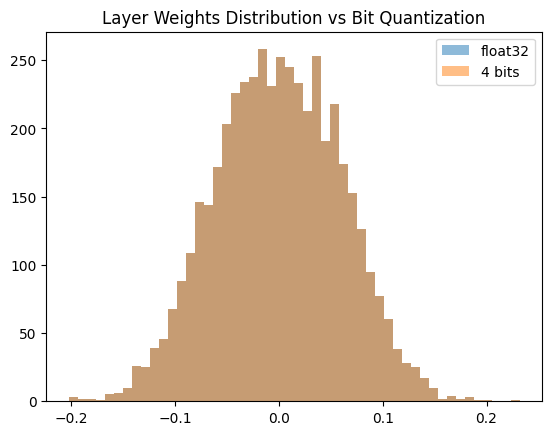

In [470]:
weights = extractor.conv1.weight.view(-1)
weights = weights.cpu().detach().numpy()

w_quantize = copy_model.conv1.weight.view(-1)
w_quantize = w_quantize.cpu().detach().numpy()


# # plot weighst as a histogram
import matplotlib.pyplot as plt
plt.hist(weights, bins=50, alpha=0.5, label="float32")
plt.hist(w_quantize, bins=50, alpha=0.5, label="4 bits")
plt.title("Layer Weights Distribution vs Bit Quantization")
plt.legend()
plt.show()



In [374]:
# import torch.quantization.quantize_fx as quantize_fx
# import copy

# copy_model.eval()

# qconfig_dict = {"": torch.quantization.default_dynamic_qconfig}
# model_prepared = quantize_fx.prepare_fx(copy_model, qconfig_dict)
# copy_model = quantize_fx.convert_fx(model_prepared)

In [497]:
x = torch.rand(1,3,3,224,224, dtype=torch.float32).cuda()
copyx = copy_model(x)
regx = extractor(x)



In [498]:
copyx.view(-1)[0:5]

tensor([-0.6746,  0.2009,  1.1632,  0.8417,  0.3978], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [499]:
regx.view(-1)[0:5]

tensor([-0.6633,  0.2104,  1.1705,  0.8555,  0.3979], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [306]:
model = copy_model
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 0.692MB
